# Details of the analysis

#### Point to note:
This is not my official submission file. 

For this notebook to work, you need to install Apache Spark onto your system. The instuctions to do that can be found here:
http://spark.apache.org/docs/latest/spark-standalone.html

#### Setup:
Due to the hardware limitations of my laptop while processing large volume of data, I'm currently deploying only a small part of the data in this notebook. I've used this notebook only as a prototype to test my code. However, it would be very simple to process the entire data with a small code change. I have instructed how to do that later, in the particular cell. 

#### Things added:
The core logic of my analysis remains same in this notebook and the submission file. However databricks.com provide a easy tool to plot graph over Spark Dataframes. This was obviously not possible here.
To provide a similar experience, I've tried to plot the same graphs here using matplotlib and vincent. So there is a little difference in the look and feel. The only exception is the world map, which I would not be plotting as I'm unfamiliar with it and I'm running out of time.

#### Nature of the analysis:
I would be using mainly Apache Spark dataframes and SQL context to perform the analysis, due to it's efficiency in distributed computing. Since this is only a protype, I would be running apache spark on a single machine. Whenever required I would be switiching to pandas dataframe. I would be using matplotlib to plot any graph.

###### External Python Libraries Used:
- httpagentparser  
- numpy  
- pandas  
- matplotlib 
- iso3166 : to convert Country code
- vincent : another package to plot graphs


In [2]:
#load spark

import sys
##Set the following to your local spark installation
sys.path.append("D:/Softwares/spark/python")
try:
    from pyspark import SparkContext
    from pyspark import SparkConf
    from pyspark.sql import SQLContext
    print ("Successfully imported Spark Modules")

except ImportError as e:
    print ("Can not import Spark Modules", e)
    sys.exit(1)

sc = SparkContext("local[*]", "Bitly")
sqlContext = SQLContext(sc)

Successfully imported Spark Modules


In [13]:
#imports and initial setup
import numpy as np
import pandas as pd
import httpagentparser
from iso3166 import countries
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from matplotlib.gridspec import GridSpec
%matplotlib  inline
#method to convert Spark Dataframe to Pandas DataFrame
def rows_to_def(rows):
    return pd.DataFrame(map(lambda e: e.asDict(), rows))
  


In [12]:
##loading data : Make changes here

##Comment the following three line
DFrame = sqlContext.read.json("C:/Users/sneha/Desktop/data/dec_aa")
DFrame = DFrame.limit(1000)
#DFrame.cache()
#load the 6 tables in 6 dataframes and merge into a single one at the end
##Uncomment the following lines
"""
df1 = sqlContext.sql("C:/Users/sneha/Desktop/data/dec_aa")
df2 = sqlContext.sql("C:/Users/sneha/Desktop/data/dec_ab")
df3 = sqlContext.sql("C:/Users/sneha/Desktop/data/dec_ac")
df4 = sqlContext.sql("C:/Users/sneha/Desktop/data/dec_ad")
df5 = sqlContext.sql("C:/Users/sneha/Desktop/data/dec_ae")
df6 = sqlContext.sql("C:/Users/sneha/Desktop/data/dec_af")
DFrame = df1.unionAll(df2).unionAll(df3).unionAll(df4).unionAll(df5).unionAll(df6)
DFrame.cache()"""

'\ndf1 = sqlContext.sql("C:/Users/sneha/Desktop/data/dec_aa")\ndf2 = sqlContext.sql("C:/Users/sneha/Desktop/data/decodesab")\ndf3 = sqlContext.sql("C:/Users/sneha/Desktop/data/decodesac")\ndf4 = sqlContext.sql("C:/Users/sneha/Desktop/data/decodesad")\ndf5 = sqlContext.sql("C:/Users/sneha/Desktop/data/decodesae")\ndf6 = sqlContext.sql("C:/Users/sneha/Desktop/data/decodesaf")\nDFrame = df1.unionAll(df2).unionAll(df3).unionAll(df4).unionAll(df5).unionAll(df6)\nDFrame.cache()'

In [14]:
print "Total enteries in the dataset: " + str(DFrame.count())

Total enteries in the dataset: 1000


#### 1. Stats By Platform 

- Platforms interacting with Bitlinks the most  
- Most used browsers on Top 3 platforms to interact wit Bitlinks
- Android or OS? : Which platforms does the top 30 traffic generating countries prefer

In [15]:
#code needed for section 1  

#methods to return OS, Platform or Broswser details, given a user_Agent string
def ua_det_os(user_agent):    
    try:
        details =  httpagentparser.detect(str(user_agent))
        if 'os' in details:
            return details['os']['name']
        else:
            return None
    except:
        return None

def ua_det_platform(user_agent):  
    try:    
        details =  httpagentparser.detect(str(user_agent))
        if 'platform' in details:
            if 'dist' in details:
                return details['dist']['name'].strip()
            elif 'platform' in details:
                return details['platform']['name'].strip()     
            else:
                return None
    except:
        return None

def ua_det_browser(user_agent):   
    try:
        details =  httpagentparser.detect(str(user_agent))
        if 'browser' in details:
            return details['browser']['name']
        else:
            return None
    except:
        return None

get_os = udf(lambda x:ua_det_os(x), StringType())
get_platform = udf(lambda x:ua_det_platform(x), StringType())
get_browser = udf(lambda x:ua_det_browser(x), StringType())


In [16]:
dftest = DFrame.withColumn('os',get_os(DFrame.a)).withColumn('browser',get_browser(DFrame.a)).withColumn('platform',get_platform(DFrame.a)).select('c','a',"os","browser","platform","nk",'h','g','u')
dftest.show(5)

+---+--------------------+-------+--------------------+--------+---+-------+-------+--------------------+
|  c|                   a|     os|             browser|platform| nk|      h|      g|                   u|
+---+--------------------+-------+--------------------+--------+---+-------+-------+--------------------+
| AU|Mozilla/5.0 (Linu...|  Linux|              Chrome| Android|  1|1H8wL5c|1H8wL5d|http://www.airasi...|
| US|Mozilla/5.0 (comp...|Windows|Microsoft Interne...| Windows|  0|1xupVE6|1lj67KQ|https://cdn.adf.l...|
| US|Mozilla/4.0 (comp...|Windows|Microsoft Interne...| Windows|  0|1xupVE6|1lj67KQ|https://cdn.adf.l...|
| GB|Mozilla/5.0 (iPho...|    iOS|                null|  iPhone|  1|1z7y10j|1z7y10k|https://predikta....|
| CN|Mozilla/5.0 (iPad...|    iOS|              Safari|    IPad|  0|1pv5AIm|1pv5AIn|http://www.hasbro...|
+---+--------------------+-------+--------------------+--------+---+-------+-------+--------------------+
only showing top 5 rows



In [17]:
#Platforms interacting with Bitlinks the most  

dfc = dftest.groupBy("platform").count().sort("count",ascending=False).select("platform","count")
plt.style.use('ggplot')
pd_dfc = rows_to_def(dfc.collect())
pd_dfc = pd_dfc.set_index('platform')


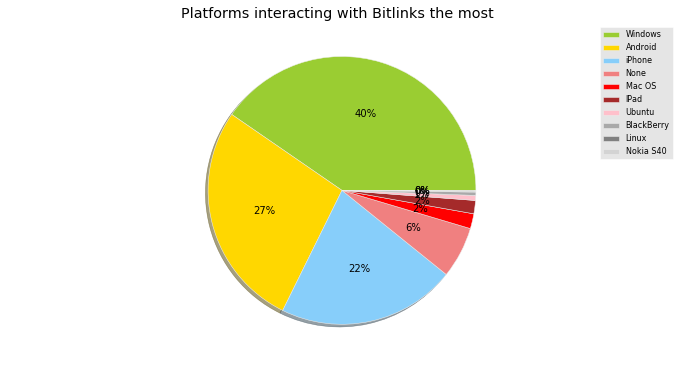

In [18]:
# Graph : Platforms interacting with Bitlinks the most  
plt.figure(figsize=(12,6))
plt.style.use('ggplot')
labels = pd_dfc.index
sizes = pd_dfc.values
plt.axis('equal')
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral' , 'red', 'brown', 'pink', 'darkgrey' ,'grey', 'lightgrey' ]

patches = plt.pie(sizes, radius = 1, shadow=True, autopct='%1.f%%', colors=colors)
plt.legend(patches[0], labels, loc='upper right', fontsize=8)
plt.title("Platforms interacting with Bitlinks the most  ")
plt.show()
#pd_dfc

In [19]:
#Most used browsers on Top 3 platforms to interact with Bitlinks
df_android = dftest.groupBy("platform","browser").count().sort("count",ascending=False).select("platform","browser","count").where(dftest['platform'] == "Android")

df_iPhone = dftest.groupBy("platform","browser").count().sort("count",ascending=False).select("platform","browser","count").where(dftest['platform'] == "iPhone")

df_Windows = dftest.groupBy("platform","browser").count().sort("count",ascending=False).select("platform","browser","count").where(dftest['platform'] == "Windows")

pd_dfc2 = rows_to_def(df_android.unionAll(df_iPhone).unionAll(df_Windows).collect())
pd_dfc2 = pd_dfc2.set_index(['platform','browser'])

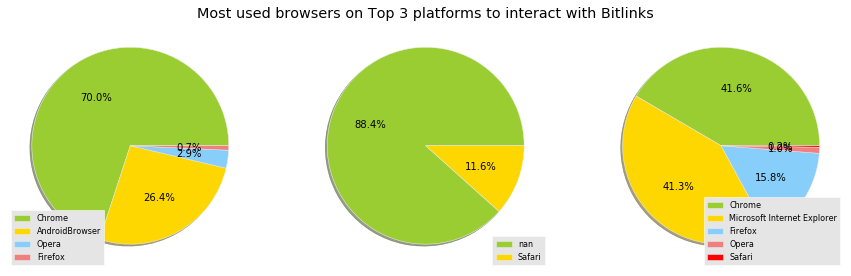

In [20]:
#Graph : Most used browsers on Top 3 platforms to interact with Bitlinks

the_grid = GridSpec(1, 3)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral' , 'red', 'brown', 'pink', 'darkgrey' ,'grey', 'lightgrey' ]
plt.figure(figsize=(15,12))

plt.subplot(the_grid[0, 0], aspect=1)
patches = plt.pie(pd_dfc2.loc['Android'].values,colors=colors, autopct='%1.1f%%', shadow=True)
plt.legend(patches[0], labels=pd_dfc2.loc['Android'].index, loc='lower left', fontsize=8)


plt.subplot(the_grid[0, 1], aspect=1)
patches = plt.pie(pd_dfc2.loc['iPhone'].values,colors=colors,  autopct='%1.1f%%', shadow=True)
plt.legend(patches[0], labels=pd_dfc2.loc['iPhone'].index, loc='lower right', fontsize=8)

plt.title("Most used browsers on Top 3 platforms to interact with Bitlinks")

plt.subplot(the_grid[0, 2], aspect=1)
patches = plt.pie(pd_dfc2.loc['Windows'].values,colors=colors, autopct='%1.1f%%', shadow=True)
plt.legend(patches[0], labels=pd_dfc2.loc['Windows'].index, loc='lower right', fontsize=8)

plt.show()
#pd_dfc2

In [52]:
#Android or OS? : Which platforms does the top 20 traffic generating countries prefer
df_top20 = dftest.groupBy('c').count().sort('count',ascending = False).limit(20)
dftest.registerTempTable('dftest')
pdf_top20  = rows_to_def(df_top20.collect())

top20_countries = pdf_top20.set_index('c' ).index.get_level_values('c')
sql_string1 = "SELECT c,platform,count(c) FROM dftest WHERE (c IN ("
sql_string3 = "')) AND (platform = 'Android' or platform = 'iPhone') GROUP BY c,platform"
sql_string2 = ""
sql_string4 = []


for i,val in enumerate(top20_countries):    
    sql_string4.append((val))    
for i in range(19):    
    sql_string2 =sql_string2 + "'" + str(sql_string4[i]) + "'," 
sql_string2 = sql_string2 + "'" +sql_string4[19]

sql_string = sql_string1 + sql_string2 +sql_string3
pdf_top20_plat = rows_to_def(sqlContext.sql(sql_string).groupBy('c','platform').sum().sort('c').collect())
pdf_top20_plat = pdf_top20_plat.set_index(['c','platform'])
df2 = pd.DataFrame([0] ,index = [['AR'],['iPhone']],columns=['sum(_c2)'])
pdf_top20_plat = pdf_top20_plat.append(df2)
df2 = pd.DataFrame([0] ,index = [['CA'],['Android']],columns=['sum(_c2)'])
pdf_top20_plat = pdf_top20_plat.append(df2)
pdf_top20_plat.sort_index( inplace= True)


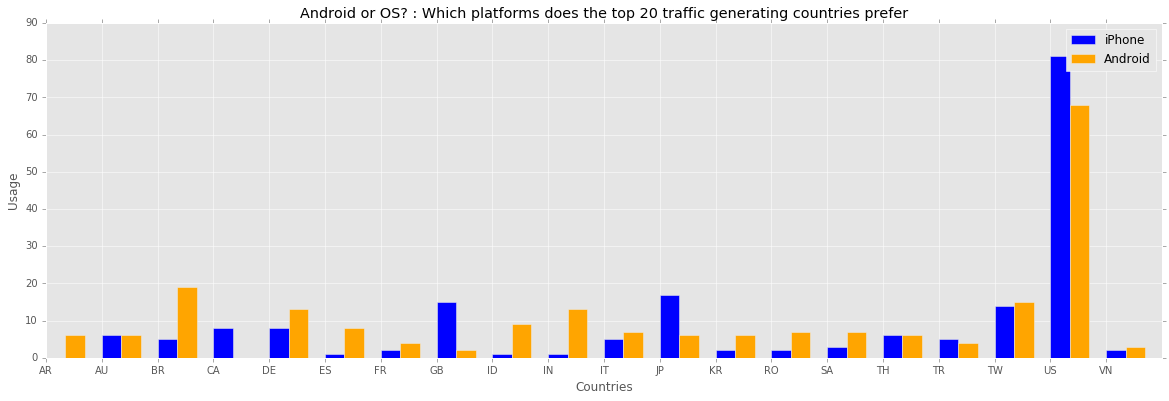

In [64]:
#Graph : #Android or OS? : Which platforms does the top 30 traffic generating countries prefer
N = 20
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
iPhoneValue = pdf_top20_plat.loc[(pdf_top20_plat.index.get_level_values('platform') == 'iPhone')].values
AndroidValue =  pdf_top20_plat.loc[(pdf_top20_plat.index.get_level_values('platform') == 'Android')].values

plt.figure(figsize=(20,6))
plt.bar(ind, iPhoneValue, width, color='b')
plt.bar(ind + width, AndroidValue, width, color='orange')

plt.title('Android or OS? : Which platforms does the top 20 traffic generating countries prefer')
plt.xlabel('Countries')
plt.ylabel('Usage')
plt.xticks(range(20), sorted(set(pdf_top20_plat.index.get_level_values('c'))))
plt.legend(["iPhone", "Android"])
plt.show()


###### Conclusion

Please check the main submission file (html)

#### 2 .Stats By Country

- Coutries with maximum traffic
   - Box Plot
- Countries with maximum potential to expand traffic in
  - Percentage of traffic generated by the top 10 countries
  - Number of Internet users (per country) interacting with Bitlinks
    - For this result, I've used the data the number of Internet users per country.
    - The result has been acquired from here: https://en.wikipedia.org/wiki/List_of_countries_by_number_of_Internet_users
    - The actual traffic has been mapped to the top 10 countries with most internet users

In [66]:
from pyspark.sql.functions import lit
pdf_topInternetUsers =pd.DataFrame.from_csv('C:/Users/sneha/Desktop/data/InternetUsers.csv')
pdf_topInternetUsers = pdf_topInternetUsers.reset_index()
df_topInternetUsers = sqlContext.createDataFrame(pdf_topInternetUsers)
df_topInternetUsers.registerTempTable('InternetUsers')

def ua_get_alpha3(alpha2):   
    try:
        str_alpha2 =  str(alpha2)
        return countries.get(str_alpha2).alpha3
    except:
        return None
#registering custom User Defined Functions
get_alpha3 = udf(lambda x:ua_get_alpha3(x), StringType())

df_internetusers = sqlContext.sql("select * from InternetUsers")
df_internetusers_with_code = df_internetusers.withColumn("c3_1", lit(get_alpha3(df_internetusers.Country)))


print "Countries with Most Internet users (Top 10)"
pdf_internetusers_with_code = rows_to_def(df_internetusers_with_code.collect())
df_topInternetUsers.show(10)

Countries with Most Internet users (Top 10)
+--------------+-------------+
|       Country|InternetUsers|
+--------------+-------------+
|         China|    668110314|
|         India|    402000000|
| United States|    266441302|
|         Japan|    109755777|
|        Brazil|    103720965|
|        Russia|     87495296|
|     Indonesia|     78000000|
|       Germany|     68131244|
|       Nigeria|     65675984|
|United Kingdom|     56954584|
+--------------+-------------+
only showing top 10 rows



In [67]:
#Coutries with maximum traffic :Bar
df_topInternetUsers
dfc = DFrame.withColumn("c3", lit(get_alpha3(DFrame.c))).select("c","c3").groupBy("c3").count().sort("count",ascending=False).select("c3","count")
pdfc = rows_to_def(dfc.limit(20).collect())
pdfc = pdfc.set_index('c3')

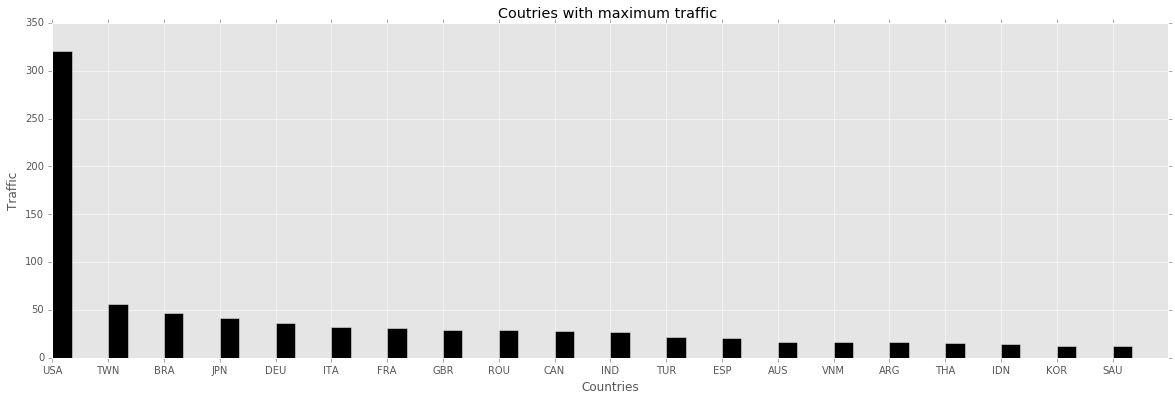

In [68]:
#Graph : #Coutries with maximum traffic :Bar
N = 20
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
traffic_vals = pdfc.values
plt.figure(figsize=(20,6))
plt.bar(ind, traffic_vals, width, color='k')

plt.title('Coutries with maximum traffic ')
plt.xlabel('Countries')
plt.ylabel('Traffic')
plt.xticks(range(20), pdfc.index.get_level_values('c3'))

plt.show()

In [69]:
#Countries with maximum potential to expand traffic in
df_ccc = df_internetusers_with_code.join(dfc, dfc['c3'] == df_internetusers_with_code['c3_1']).sort('InternetUsers', ascending = False)
pdc_ccc = rows_to_def(df_ccc.limit(20).collect())

Please note that the following graph will need the entire dataset to show correctly.
Currently only 2000 enteries has been loaded into the system, hence only one line is visible.

In [70]:
#Graph: Countries with maximum potential to expand traffic in
import vincent
vincent.core.initialize_notebook()

line = vincent.Line(pdc_ccc[['InternetUsers','count']])
line.axis_titles(x='Country', y='Usage vs Traffic(Count)')
line.legend(title='Traffic vs Usage of Top 20 Countries with most Internet Users')
line.display()
pdc_ccc[['Country']]

,Country
0,China
1,India
2,United States
3,Japan
4,Brazil
5,Indonesia
6,Germany
7,Nigeria
8,United Kingdom
9,France


#### Conclusion

- Please see the original submission file



#### 3. Stats on Repeat Clients

- Number of new cookies in the hours  
- Most preferred platform for repeat users
- Most preferred platform for new users

In [71]:
#Number of new cookies in the hours
pdf_nk = rows_to_def(DFrame.groupBy('nk').count().collect())
pdf_nk = pdf_nk.set_index('nk')

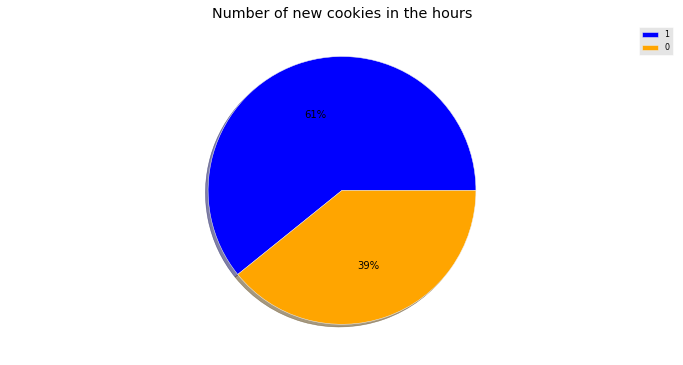

In [72]:
#Graph : Number of new cookies in the hours
plt.figure(figsize=(12,6))
plt.style.use('ggplot')
labels = pdf_nk.index
sizes = pdf_nk.values
plt.axis('equal')
colors = ['blue', 'orange' ]

patches = plt.pie(sizes, radius = 1, shadow=True, autopct='%1.f%%', colors=colors)
plt.legend(patches[0], labels, loc='upper right', fontsize=8)
plt.title("Number of new cookies in the hours")
plt.show()
#pd_dfc

In [73]:
##Most preferred platform for repeat users

pdc_nk1 = rows_to_def(dftest.where(DFrame['nk'] == 1).groupBy('platform').count().sort('count',ascending = False).collect())
pdc_nk1 = pdc_nk1.set_index('platform')

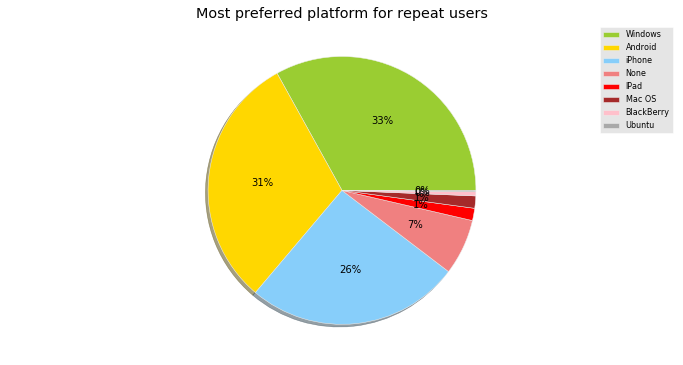

In [74]:
#Graph : Number of new cookies in the hours
plt.figure(figsize=(12,6))
plt.style.use('ggplot')
labels = pdc_nk1.index
sizes = pdc_nk1.values
plt.axis('equal')
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral' , 'red', 'brown', 'pink', 'darkgrey' ,'grey', 'lightgrey' ]

patches = plt.pie(sizes, radius = 1, shadow=True, autopct='%1.f%%', colors=colors)
plt.legend(patches[0], labels, loc='upper right', fontsize=8)
plt.title("Most preferred platform for repeat users")
plt.show()
#pd_dfc

In [75]:
##Most preferred platform for new users

pdc_nk0 = rows_to_def(dftest.where(DFrame['nk'] == 0).groupBy('platform').count().sort('count',ascending = False).collect())
pdc_nk0 = pdc_nk0.set_index('platform')

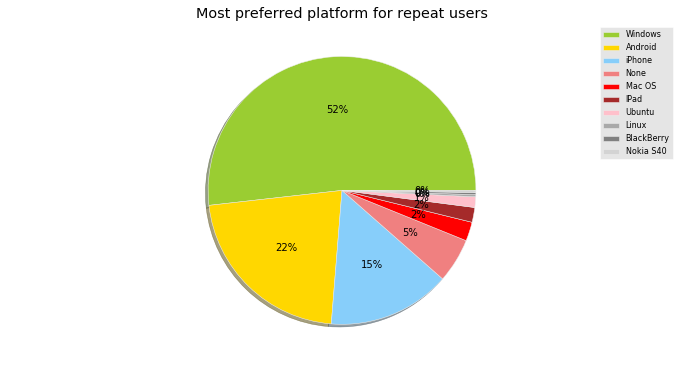

In [76]:
#Graph : Most preferred platform for new users
plt.figure(figsize=(12,6))
plt.style.use('ggplot')
labels = pdc_nk0.index
sizes = pdc_nk0.values
plt.axis('equal')
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral' , 'red', 'brown', 'pink', 'darkgrey' ,'grey', 'lightgrey' ]

patches = plt.pie(sizes, radius = 1, shadow=True, autopct='%1.f%%', colors=colors)
plt.legend(patches[0], labels, loc='upper right', fontsize=8)
plt.title("Most preferred platform for repeat users")
plt.show()
#pd_dfc

#### Conclusion
    - Please see the original submission

#### 4. Stats on Domains of the visited websites/urls

- Most visited hostnames

In [77]:
#Most visited hostnames
import urlparse

def ua_get_hostname(url):   
    try:
      hostname = urlparse.urlparse(str(url)).hostname
      return hostname
    except:
        return None

#registering custom User Defined Functions
get_url = udf(lambda x:ua_get_hostname(x), StringType())


df_hostname = dftest.withColumn("hostname", get_url('u'))
df_results = df_hostname.groupBy(df_hostname['hostname']).count().sort("count",ascending = False)
pdc_result = rows_to_def(df_results.where(df_results['hostname'] != 'null').limit(10).collect())
pdc_result = pdc_result.set_index('hostname')


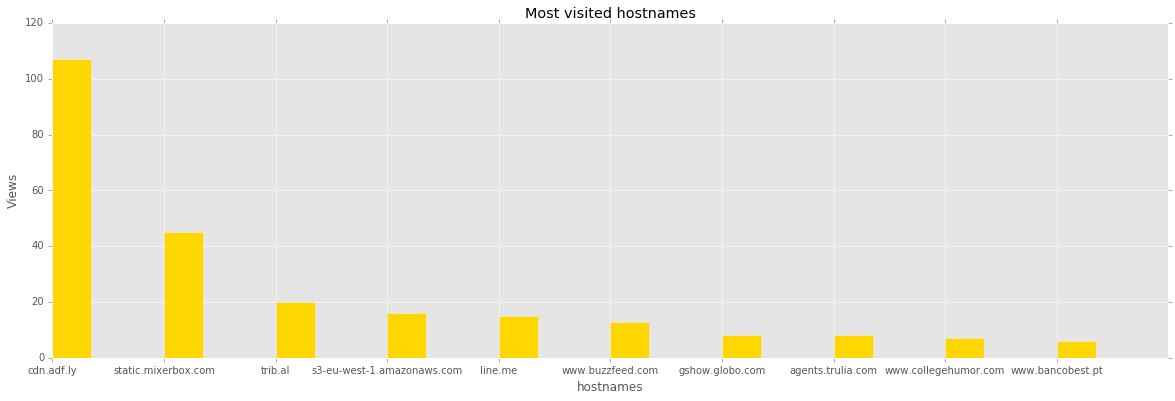

In [78]:
#Graph: Most visited hostnames
N = 10
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
host_vals = pdc_result.values
plt.figure(figsize=(20,6))
plt.bar(ind, host_vals, width, color='gold')

plt.title('Most visited hostnames')
plt.xlabel('hostnames')
plt.ylabel('Views')
plt.xticks(range(10), pdc_result.index.get_level_values('hostname'))

plt.show()